In [1]:
### Importing Required Libraries

In [2]:
from nltk.corpus import stopwords
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

In [4]:
### Loading the active.csv file

In [5]:
df=pd.read_csv('train.csv')
df.head()

,text,target
0,Credit Reporting Agencies continue to report X...,1
1,"On Wednesday, XXXX XXXX of 2015, I was in rece...",2
2,These addresses are errors. \n\nXXXX XXXX XXXX...,1
3,I have not paid on my mortage ( for a property...,3
4,XXXX/XXXX/XXXX our names are XXXX & XXXX. we h...,3


In [6]:
### PREPROCESSING

In [7]:
# checking for null and missing values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5000 non-null   object
 1   target  5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [8]:
df.shape

(5000, 2)

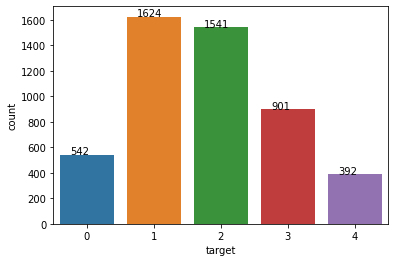

In [9]:
ax =sns.countplot(x ='target', data = df)
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

In [10]:
# I am droping the duplicate rows becasue they are giving the same information
# and if I drop that then it will increase the computation time without any information loss.

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.shape # (5000-4957=43; Total 43 duplicate value droped)

(4959, 2)

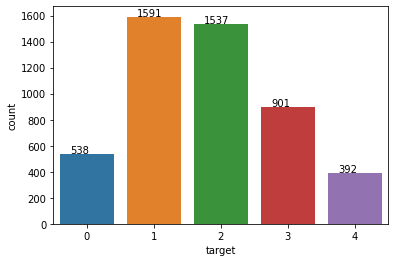

In [13]:
# checking for unbalanced data
ax =sns.countplot(x ='target', data = df)
for p in ax.patches:
    ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))
    
# data is mildly imbalanced, so if we want we can ignore it
# But I have handle this issue while applying logistic regression
# by taking balanced weight.

In [14]:
# Removing stop words

In [15]:
STOPWORDS = set(stopwords.words('english'))
special_character_remover = re.compile('[/(){}\[\]\|@,;]')
extra_symbol_remover = re.compile('[^0-9a-z #+_]')

In [16]:
def clean_text(text):
    text = text.lower()  # converting to lower text
    text = special_character_remover.sub(' ', text)  
    text = extra_symbol_remover.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
df['text'] = df['text'].apply(clean_text)

In [17]:
df.head()

,text,target
0,credit reporting agencies continue report xxxx...,1
1,wednesday xxxx xxxx 2015 receipt warrant debt ...,2
2,addresses errors xxxx xxxx xxxx xxxx xxxx nv x...,1
3,paid mortage property reside since xxxx 2012 f...,3
4,xxxx xxxx xxxx names xxxx xxxx current loan w ...,3


In [18]:
### Spliting into Train and Test set

In [19]:
from sklearn.model_selection import train_test_split
X = df.text
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [20]:
my_tags = ['0','1','2','3','4']

In [21]:
### APPLYING Logistic Regression

In [22]:
# I am using count vectorization and tf-idf approch for multi class classification

In [23]:
lr = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(class_weight='balanced')),  # I have used balanced to handle imbalanced issue
              ])

lr.fit(X_train,y_train)
y_pred1 = lr.predict(X_test)

print(f"Accuracy is : {accuracy_score(y_pred1,y_test)}")

Accuracy is : 0.7671370967741935


In [24]:
## Classification_report for Logistic
print('Classification_report for Logistic \n')
print(classification_report(y_test, y_pred1,target_names=my_tags))

Classification_report for Logistic 

              precision    recall  f1-score   support

           0       0.49      0.66      0.56       111
           1       0.75      0.63      0.68       322
           2       0.84      0.82      0.83       321
           3       0.91      0.96      0.93       163
           4       0.74      0.89      0.81        75

    accuracy                           0.77       992
   macro avg       0.75      0.79      0.76       992
weighted avg       0.78      0.77      0.77       992



In [25]:
### APPLYING MultinomialNB

In [26]:
naivebayes = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
naivebayes.fit(X_train, y_train)

y_pred2 = naivebayes.predict(X_test)

print(f'accuracy {accuracy_score(y_pred2,y_test)}')

accuracy 0.6844758064516129


In [27]:
## Classification_report for MultinomialNB
print('Classification_report for MultinomialNB \n')

print(classification_report(y_test, y_pred2,target_names=my_tags))

Classification_report for MultinomialNB 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       111
           1       0.60      0.88      0.71       322
           2       0.72      0.85      0.78       321
           3       0.88      0.73      0.80       163
           4       1.00      0.07      0.12        75

    accuracy                           0.68       992
   macro avg       0.64      0.50      0.48       992
weighted avg       0.65      0.68      0.62       992



In [28]:
# The reason for such a poor score is prior probability
# naive bayes depends upon it but as we know that class o and class 4 prior probabilty are less becasue of 
# imbalanced dataset

In [29]:
### APPLYING Xgboost 

In [30]:
xgboost = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', XGBClassifier(verbosity = 0)),
              ])
xgboost.fit(X_train, y_train)

y_pred3 = xgboost.predict(X_test)

print(f'accuracy {accuracy_score(y_pred3,y_test)}')

accuracy 0.7762096774193549


In [31]:
# I tried fine tunning xgb with various other prameter but the result was 
# not good. that's why I settled for default parameter.

In [32]:
## Classification_report  for XGBOOST
print('Classification_report for XGBOOST')
print(classification_report(y_test, y_pred3,target_names=my_tags))

Classification_report for XGBOOST
              precision    recall  f1-score   support

           0       0.73      0.40      0.51       111
           1       0.71      0.77      0.74       322
           2       0.80      0.85      0.82       321
           3       0.90      0.88      0.89       163
           4       0.77      0.84      0.80        75

    accuracy                           0.78       992
   macro avg       0.78      0.75      0.75       992
weighted avg       0.78      0.78      0.77       992



In [33]:
# OUT OF ALL THREE MODEL Logistic is best.
# XGB boost is sligthly better than logistic in terms of overall score
# but logistic is performing better in all classes comapred to xbg
# and logistic is taking very less time compared to the xgb

In [34]:
### FUTURE work

In [35]:
# we can try word2vec instead of count vectorization